In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.utils.data as utils
import warnings
import time
import copy
import json
import random
from torch.optim import lr_scheduler
warnings.filterwarnings('ignore')

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import transforms
import cv2

df = pd.read_csv("../input/data/train/train.csv")
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [2]:

root = '../input/data/train/images/'
data_list = pd.DataFrame(None, columns = ['path', 'label'])
for path in df['path']:
    Id, gender, race, age = path.split("_")
    age = int(age)
    age_point = 0
    if age < 30:
        age_point = 0
    elif age < 57:
        age_point = 1
    else:
        age_point = 2
        
    gender_point = 0
    if gender == "male":
        gender_point = 0
    else:
        gender_point = 3
        
    for image in list(os.listdir(os.path.join(root, path))):
        if image[0] == ".":
            continue
        if image.split('.')[0] == 'normal':
            label = 12 + age_point + gender_point
            data = {'path' : os.path.join(f'{root}',  path, f'{image}'), 'label' : label}
            data_list = data_list.append(data, ignore_index = True)
        elif image.split('.')[0] == 'incorrect_mask':
            label = 6 + age_point + gender_point
            data = {'path' : os.path.join(f'{root}', path, f'{image}'), 'label' : label}
            data_list = data_list.append(data, ignore_index = True)
        elif 'mask' in image.split('.')[0]:
            label = age_point + gender_point
            data = {'path' : os.path.join(f'{root}',  path, f'{image}'), 'label' : label}
            data_list = data_list.append(data, ignore_index = True)
            
data_list

,path,label
0,../input/data/train/images/000001_female_Asian...,4
1,../input/data/train/images/000001_female_Asian...,10
2,../input/data/train/images/000001_female_Asian...,4
3,../input/data/train/images/000001_female_Asian...,4
4,../input/data/train/images/000001_female_Asian...,4
...,...,...
18895,../input/data/train/images/006959_male_Asian_1...,0
18896,../input/data/train/images/006959_male_Asian_1...,0
18897,../input/data/train/images/006959_male_Asian_1...,0
18898,../input/data/train/images/006959_male_Asian_1...,12


In [3]:
test_df = pd.read_csv('../input/data/eval/submission.csv')
test_df.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,14
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,2
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,14
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,14
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12


In [4]:
df = pd.read_csv('../input/data/train/new_train.csv')
df

,path,label
0,../input/data/train/images/003887_female_Asian...,4
1,../input/data/train/images/003887_female_Asian...,10
2,../input/data/train/images/003887_female_Asian...,4
3,../input/data/train/images/003887_female_Asian...,4
4,../input/data/train/images/003887_female_Asian...,4
...,...,...
15115,../input/data/train/images/001244_male_Asian_2...,0
15116,../input/data/train/images/001244_male_Asian_2...,0
15117,../input/data/train/images/001244_male_Asian_2...,0
15118,../input/data/train/images/001244_male_Asian_2...,12


In [5]:
df = pd.read_csv('../input/data/train/new_train.csv')
df

,path,label
0,../input/data/train/images/003887_female_Asian...,4
1,../input/data/train/images/003887_female_Asian...,10
2,../input/data/train/images/003887_female_Asian...,4
3,../input/data/train/images/003887_female_Asian...,4
4,../input/data/train/images/003887_female_Asian...,4
...,...,...
15115,../input/data/train/images/001244_male_Asian_2...,0
15116,../input/data/train/images/001244_male_Asian_2...,0
15117,../input/data/train/images/001244_male_Asian_2...,0
15118,../input/data/train/images/001244_male_Asian_2...,12


In [6]:
mask_dict = {}
for i in range(18):
    if i <= 5:
        mask_dict[i] = 0
    elif i <= 11:
        mask_dict[i] = 1
    else:
        mask_dict[i] = 2
df['Mask'] = df['label'].map(mask_dict)
# df.head(3)
# 0 : wear
# 1 : Incorrect
# 2 : No Mask

In [7]:
gender_dict = {}
for i in range(18):
    if i <= 2 or (6 <= i <= 8) or (12 <= i <= 14):
        gender_dict[i] = 0
    else:
        gender_dict[i] = 1
df['Gender'] = df['label'].map(gender_dict)
# df.head(3)
# 0 : Male
# 1 : Female

In [8]:
age_dict = {}
for i in range(18):
    if i % 3 == 0:
        age_dict[i] = 0
    elif i % 3 == 1:
        age_dict[i] = 1
    else:
        age_dict[i] = 2
df['Age'] = df['label'].map(age_dict)
# df.head(3)
# 0 : young (< 30)
# 1 : middle ( 30 <= age < 60)
# 2 : old (>= 60)

In [9]:
import albumentations as A
import albumentations.pytorch as py 
transform = A.Compose([
    A.Resize(224,224),
    py.ToTensorV2(),
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
import torch.nn.functional as F

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self):
        super(LabelSmoothingCrossEntropy, self).__init__()
    def forward(self,x,target,smoothing=0.1):
        confidence = 1. - smoothing
        logprobs = F.log_softmax(x,dim=-1)
        nll_loss = -logprobs.gather(dim=-1,index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + smoothing * smooth_loss
        return loss.mean()

In [11]:
class FocalLoss(nn.Module):
    def __init__(self,gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = LabelSmoothingCrossEntropy()
    
    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p)**self.gamma * logp
        return loss.mean()

In [12]:
import albumentations as A
import albumentations.pytorch as py

class MaskDataset(Dataset):
    def __init__(self, df, transforms = None, label_filter = None):
        """
            Args:
                label_filter : List type으로 입력 (0~17 사잇값으로)
                    ex) label_filter = [1, 2, 5, 7]
        """
        self.label_filter = label_filter
        if label_filter is not None:
            df = df[df['label'].isin(label_filter) == True]
            df = df.reset_index(drop = True)
        self.classes = torch.tensor(df['label'])
        self.img_path = df.path.values
        self.transforms = transform
        self.aug = A.Compose([
           #A.CLAHE(p=0.2),
            A.ToGray(p=0.2),
            #A.RandomBrightnessContrast(brightness_limit=(0.4, 0.6), contrast_limit=(1, 1), p=0.2),
            A.CoarseDropout(max_holes=100,max_height=5,max_width=5,fill_value=128,p=0.2),
            A.ChannelDropout(channel_drop_range=(1,2), fill_value=255, p =0.2),
            A.MultiplicativeNoise(per_channel=True,elementwise=True,p=0.2),
            A.HorizontalFlip(p=0.2),
            A.CenterCrop(height=300,width=200,p=0.2),
            A.Resize(224,224),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            py.transforms.ToTensorV2(),
        ])
    def __len__(self):
        return len(self.classes)
    
    def get_labels(self):
        return self.classes
    
    def __getitem__(self, idx):
        
        img_path = self.img_path[idx]
        label = self.classes[idx]
        img = Image.open(img_path)
        if self.transforms is not None:
            img = self.aug(image = np.array(img))
        
        return img, label

In [13]:
class testDataset(Dataset):
    def __init__(self,img_path,transform):
        self.img_path = img_path
        self.transform = transform
        
    def __getitem__(self, index):
        image = Image.open(self.img_path[index])
        
        if self.transform:
            image = self.transform(image)
        return image
    
    def __len__(self):
        return len(self.img_path)

In [14]:
import torchsampler

In [15]:
import albumentations as A
import albumentations.pytorch
mask_dataset = MaskDataset(df = df)
next(iter(mask_dataset))

({'image': tensor([[[-0.1657, -0.9192, -1.2274,  ...,  0.9132,  0.8447,  1.0331],
           [-0.1828, -0.8678, -1.2617,  ...,  1.1700,  1.2043,  1.1872],
           [-0.2171, -0.7993, -1.3644,  ...,  1.0159,  1.0331,  1.0844],
           ...,
           [ 0.5364,  0.4166,  0.6221,  ...,  0.9646,  0.9474,  0.8961],
           [ 0.6049,  0.5364,  0.6734,  ...,  0.9303,  0.9474,  0.9303],
           [ 0.5536,  0.4851,  0.6563,  ...,  1.1529,  1.2043,  1.0844]],
  
          [[-0.2150, -0.7227, -1.1954,  ...,  1.0980,  1.0630,  1.1506],
           [-0.0224, -0.8627, -1.2479,  ...,  1.1331,  1.3256,  1.2381],
           [-0.1450, -0.7227, -1.2829,  ...,  1.1506,  1.1856,  1.1856],
           ...,
           [-1.5630, -1.5280, -1.4755,  ...,  1.3256,  1.0280,  1.1155],
           [-1.5280, -1.5105, -1.4405,  ...,  1.0105,  1.0455,  0.9755],
           [-1.5630, -1.5630, -1.5455,  ...,  1.2556,  1.0105,  1.0630]],
  
          [[-0.1487, -0.8633, -1.1247,  ...,  1.1934,  1.1411,  1.0539],
  

In [16]:
BATCH_SIZE = 128
mask_loader = DataLoader(mask_dataset,sampler=torchsampler.ImbalancedDatasetSampler(mask_dataset),batch_size = BATCH_SIZE,num_workers=4)
inputs,classes = next(iter(mask_loader))

In [17]:
from efficientnet_pytorch import EfficientNet

In [18]:
image_size = EfficientNet.get_image_size('efficientnet-b0')
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=18)


Loaded pretrained weights for efficientnet-b0


In [19]:
batch_size  = 128
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

## make dataset
from torchvision import transforms, datasets

## data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_idx, tmp_idx = train_test_split(list(range(len(mask_dataset))), test_size=0.2, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(mask_dataset, train_idx)
tmp_dataset       = Subset(mask_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test']  = Subset(tmp_dataset, test_idx)

## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(mask_dataset,
                                              batch_size=batch_size,
                                              sampler=torchsampler.ImbalancedDatasetSampler(mask_dataset),
                                              num_workers=4)
#print(next(iter(dataloaders['train'])))
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 128,  tvt : 119 / 12 / 12


In [20]:
next(iter(datasets['test']))

({'image': tensor([[[ 1.4954,  1.6324,  1.5639,  ...,  1.6153,  1.5125,  1.3070],
           [ 1.5468,  1.7694,  1.6153,  ...,  1.2214,  1.6153,  1.6324],
           [ 1.4269,  1.5810,  1.2728,  ...,  1.6153,  1.1872,  1.1872],
           ...,
           [-0.8678, -0.8335, -0.7308,  ...,  0.4851,  1.8722,  1.6667],
           [-0.7137, -0.7993, -0.7993,  ...,  0.2967,  1.6153,  2.0263],
           [-0.8164, -0.7308, -0.7308,  ...,  0.2453,  0.8961,  1.8722]],
  
          [[ 1.7458,  1.7633,  1.5532,  ...,  1.5707,  1.5882,  1.6933],
           [ 1.6583,  1.3957,  1.6408,  ...,  1.6232,  1.8508,  1.5357],
           [ 1.6408,  1.5357,  1.5007,  ...,  1.5357,  1.3957,  1.4482],
           ...,
           [-0.6527, -0.7402, -0.5651,  ...,  0.6954,  1.6583,  1.6758],
           [-0.6352, -0.6001, -0.6001,  ...,  0.3452,  1.4482,  1.9384],
           [-0.5826, -0.6001, -0.5301,  ...,  0.4153,  0.8179,  2.0084]],
  
          [[ 1.7337,  1.6814,  2.0474,  ...,  1.9777,  1.9603,  1.6117],
  

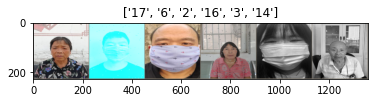

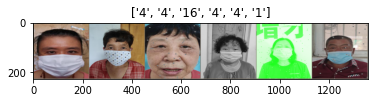

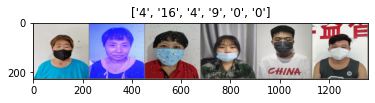

In [21]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 6

class_names = {
    "0":"0",
    "1":"1",
    "2":"2",
    "3":"3",
    "4":"4",
    "5":"5",
    "6":"6",
    "7":"7",
    "8":"8",
    "9":"9",
    "10":"10",
    "11":"11",
    "12":"12",
    "13":"13",
    "14":"14",
    "15":"15",
    "16":"16",
    "17":"17"
    
}

# train check
inputs, classes = next(iter(dataloaders['train']))
inputs = list(inputs.values())[-1]
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
inputs = list(inputs.values())[-1]
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs,classes = next(iter(dataloaders['test']))
inputs = list(inputs.values())[-1]
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [22]:
import wandb

wandb.init(project = "Mask_Project(level1)",entity="hbage",
          config = {
              "learning_rate": 0.05,
              "epoch": 10,
              "batch_size" : 128
          })
wandb.run.name = "efficient_b0"

wandb: Currently logged in as: kihoon (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [23]:
from sklearn.metrics import f1_score

def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    f1 = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = list(inputs.values())[-1].to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            if phase == 'valid':
                labels = labels.to('cpu')
                preds = preds.to('cpu')
                f1 = f1_score(labels,preds,average='macro')
            #f1 = sklearn.metrics.f1_score(labels,torch.argmax(outputs.cpu(),1), average = "marco")
            
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f} f1: {:.4f}'.format(phase, epoch_loss, epoch_acc,f1))
            wandb.log({'loss': epoch_loss, 'accuracy': epoch_acc, 'f1': f1})
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'mask_model1.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [24]:
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = LabelSmoothingCrossEntropy()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [25]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.42 Acc: 66.9 f1: 0.0000
valid Loss: 1.12 Acc: 78.4 f1: 0.7326
==> best model saved - 0 / 78.4
Epoch 1/9
----------
train Loss: 0.94 Acc: 85.5 f1: 0.7326
valid Loss: 0.94 Acc: 84.3 f1: 0.8738
==> best model saved - 1 / 84.3
Epoch 2/9
----------
train Loss: 0.83 Acc: 91.2 f1: 0.8738
valid Loss: 0.81 Acc: 91.5 f1: 0.8860
==> best model saved - 2 / 91.5
Epoch 3/9
----------
train Loss: 0.77 Acc: 93.9 f1: 0.8860
valid Loss: 0.91 Acc: 85.2 f1: 0.8522
Epoch 4/9
----------
train Loss: 0.73 Acc: 95.5 f1: 0.8522
valid Loss: 0.72 Acc: 96.2 f1: 0.9618
==> best model saved - 4 / 96.2
Epoch 5/9
----------
train Loss: 0.70 Acc: 96.5 f1: 0.9618
valid Loss: 0.69 Acc: 97.0 f1: 0.9090
==> best model saved - 5 / 97.0
Epoch 6/9
----------
train Loss: 0.68 Acc: 97.4 f1: 0.9090
valid Loss: 0.72 Acc: 94.4 f1: 0.9294
Epoch 7/9
----------
train Loss: 0.67 Acc: 97.7 f1: 0.9294
valid Loss: 0.66 Acc: 97.7 f1: 0.9717
==> best model saved - 7 / 97.7
Epoch 8/9
----------
train Loss:

test done : loss/acc : 0.64 / 98.2


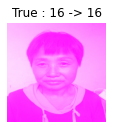

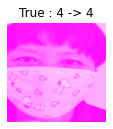

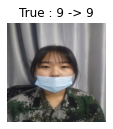

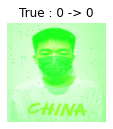

In [26]:
import ttach as tta

tf = tta.Compose(
[
    tta.HorizontalFlip(),
    tta.Rotate90(angles=[0,15]),
    tta.Multiply(factors=[0.8,0.9,1,1.1]),
])
tta_model = tta.ClassificationTTAWrapper(model,tf)


def test_and_visualize_model(model, phase = 'test', num_images=4):
    # phase = 'train', 'valid', 'test'
    
    was_training = model.training
    model.eval()
    fig = plt.figure()
    
    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = list(inputs.values())[-1].to(device)
            labels = labels.to(device)

            outputs = 0.5*tta_model(inputs)+0.5*model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

    #         if i == 2: break

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    # 예시 그림 plot
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = list(inputs.values())[-1].to(device)
            labels = labels.to(device)

            outputs = 0.5*tta_model(inputs)+0.5*model(inputs)
            _, preds = torch.max(outputs,1)       

            # 예시 그림 plot
            for j in range(1, num_images+1):
                ax = plt.subplot(num_images//2, 2, j)
                ax.axis('off')
                ax.set_title('%s : %s -> %s'%(
                    'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
                    class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
                imshow(inputs.cpu().data[j])          
            if i == 0 : break


    model.train(mode=was_training);  # 다시 train모드로
    
    ## TEST!
test_and_visualize_model(model, phase = 'test')

In [27]:
submission = pd.read_csv('../input/data/eval/info.csv')
img_dir = '../input/data/eval/images/'

img_path = [os.path.join(img_dir,img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
t_set = testDataset(img_path,transform)
loader = DataLoader(t_set,shuffle=False,batch_size=128,num_workers=4)
next(iter(loader))

model.eval()

all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = 0.5*tta_model(images)+0.5*model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

submission.to_csv('../input/data/eval/final_submission.csv',index=False)
print('done')

done
